In [0]:
import random
import imageio
import numpy as np

import matplotlib.pyplot as plt 

import tensorflow as tf

In [2]:
if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png

--2020-04-20 10:48:11--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png’

me_256.png          100%[===================>] 116.20K  --.-KB/s    in 0.02s   

2020-04-20 10:48:12 (6.82 MB/s) - ‘me_256.png’ saved [118993/118993]

--2020-04-20 10:48:14--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2965 (2.9K)

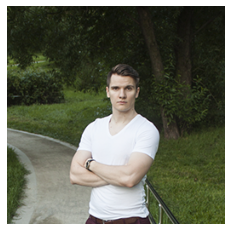

In [3]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
plt.imshow(img)
plt.axis('off')
plt.show()

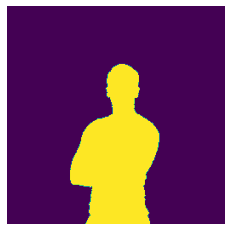

In [4]:
gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)
plt.imshow(gt, cmap='viridis')
plt.axis('off')
plt.show()

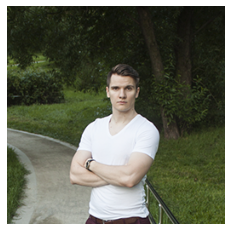

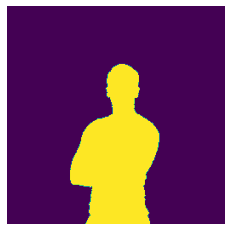

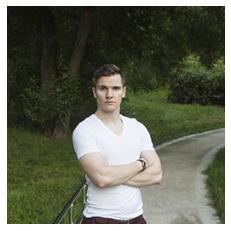

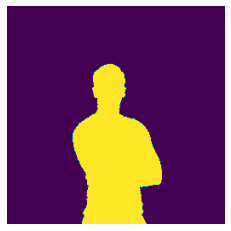

In [5]:
# Игрушечный датасет
train_x = np.stack((img, img[:, ::-1, :]))
train_y = np.stack((gt, gt[:, ::-1]))

for sample in (train_x[0], train_y[0], train_x[1], train_y[1]):
    plt.imshow(sample)
    plt.axis('off')
    plt.show()

In [0]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)        

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)         

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)         

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)   
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)   

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)     

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)     

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)     

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)           

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)     

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)       

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)     

    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)
    # картинка 256х256 с вероятностями
    
    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()                          

In [0]:
# Визуализация U-Net
if 0:
    tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
NUM_EPOCHS = 100
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/100
2/2 [==============================] - 0s 97ms/step - loss: 0.6862
Epoch 2/100
2/2 [==============================] - 0s 95ms/step - loss: 0.6516
Epoch 3/100
2/2 [==============================] - 0s 95ms/step - loss: 0.5475
Epoch 4/100
2/2 [==============================] - 0s 95ms/step - loss: 0.4089
Epoch 5/100
2/2 [==============================] - 0s 94ms/step - loss: 0.3319
Epoch 6/100
2/2 [==============================] - 0s 95ms/step - loss: 0.2738
Epoch 7/100
2/2 [==============================] - 0s 96ms/step - loss: 0.2180
Epoch 8/100
2/2 [==============================] - 0s 95ms/step - loss: 0.2239
Epoch 9/100
2/2 [==============================] - 0s 94ms/step - loss: 0.2032
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 0.2033
Epoch 11/100
2/2 [==============================] - 0s 94ms/step - loss: 0.1959
Epoch 12/100
2/2 [==============================] - 0s 94ms/step - loss: 0.1771
Epoch 13/100
2/2 [==============================]

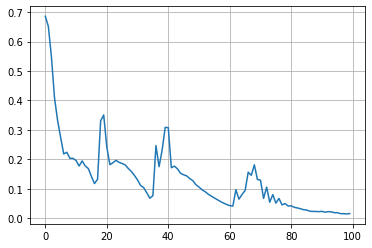

In [9]:
plt.plot(hist.history['loss'])
plt.grid(True)
plt.show()

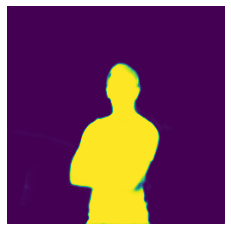

In [21]:
out = model.predict(img[None, ...])[0, ...]
plt.imshow(out[..., 0])
plt.axis('off')
plt.show()

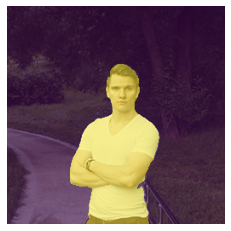

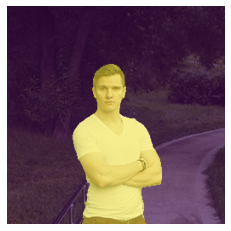

In [53]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0] > 0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5+seg_map_clr*0.5)
    plt.axis('off')
    plt.show()